<a href="https://colab.research.google.com/github/N1colasFD/Unir_CODES/blob/main/ruido_gaussiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

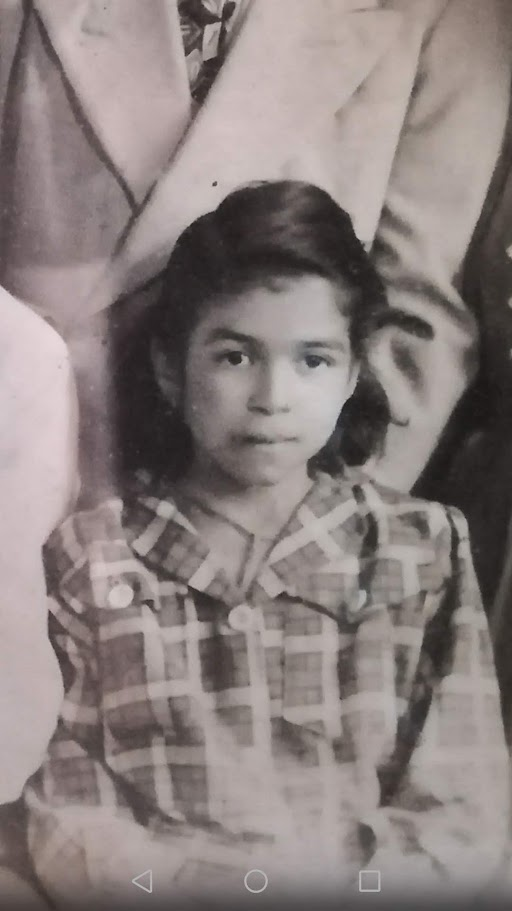

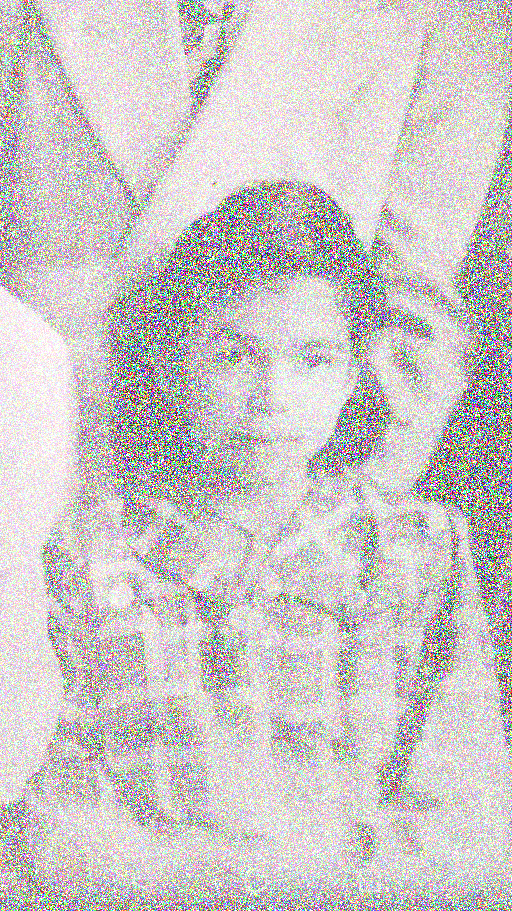

In [1]:
#importamos las bibliotecas
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

#cargamos la imagen

image = cv2.imread('/content/nina.jpg')

#creamos las funciones

def add_gaussian_noise(image, mean=0, std=30):
    # Ensure noise has the same shape and data type as the image
    noise = np.random.normal(mean, std, image.shape).astype(image.dtype)
    noisy_image = cv2.add(image, noise)
    return noisy_image

original_image = cv2.imread('/content/nina.jpg')

if original_image is None:
    raise Exception("Image not loaded properly. Check the file path.")

noisy_image = add_gaussian_noise(original_image, mean=0, std=25)

cv2_imshow(original_image)
cv2_imshow(noisy_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
# Pipeline NO ad hoc para diagnóstico y corrección de ruido guiado por histogramas
# Requisitos: OpenCV, NumPy, Matplotlib. Ejecuta en Google Colab / Jupyter.

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Utilidades de carga y plots
# -----------------------------

def load_gray_float(path):
    """Lee una imagen, la convierte a gris y la escala a [0,1]."""
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray.astype(np.float32) / 255.0

def show_hist(img, title, bins=256, rng=(0,1)):
    plt.figure(figsize=(5,3))
    plt.hist(img.ravel(), bins=bins, range=rng, density=True)
    plt.title(title); plt.xlabel("Intensidad"); plt.ylabel("Densidad")
    plt.tight_layout(); plt.show()

def imshow_pair(a, b, titles=("Original", "Resultado")):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(a, cmap="gray"); plt.title(titles[0]); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(b, cmap="gray"); plt.title(titles[1]); plt.axis("off")
    plt.tight_layout(); plt.show()

In [3]:
# -----------------------------------------
# Estimación de ruido y diagnóstico
# -----------------------------------------

def estimate_noise_sigma(img):
    """
    Estima sigma del ruido gaussiano aditivo usando:
    - Residuo = img - GaussianBlur(img) (alta frecuencia ≈ ruido)
    - MAD (median absolute deviation): sigma ≈ MAD / 0.6745
    Devuelve (sigma, residuo)
    """
    blur = cv2.GaussianBlur(img, (3,3), 0)  # suavizado ligero, no ad hoc
    resid = img - blur
    mad = np.median(np.abs(resid - np.median(resid)))
    sigma = (mad / 0.6745) + 1e-8
    return float(sigma), resid


def classify_noise(img, resid):
    """
    Diagnóstico simple guiado por histogramas:
    - Spikes en extremos (0 o 1) -> sal y pimienta
    - Residuo con campana +/- simétrica -> gaussiano
    """
    eps = 0.02  # banda de extremos en [0,1]
    spikes = np.mean(img < eps) + np.mean(img > 1 - eps)
    # Simetría del residuo
    r = resid - resid.mean()
    std = r.std() + 1e-8
    skew = np.mean((r / std)**3)  # ~0 si simétrico
    if spikes > 0.01:  # >1% en los extremos sugiere impulsivo
        ntype = "salt_pepper"
    else:
        ntype = "gaussian"
    stats = {"spikes_0_1": float(spikes), "skew_resid": float(skew)}
    return ntype, stats

In [4]:
# -----------------------------------------
# Corrección (operación principal PROPIA)
# -----------------------------------------

def denoise_gaussian_shrinkage(img, sigma):
    """
    Filtro propio tipo 'Wiener/Lee' (shrinkage local):
    y = μ + k * (x - μ), con k = max(0, (σ²_local - σ²_ruido)) / (σ²_local + ε)
    Ventana elegida en función de sigma (regla sencilla y reproducible).
    """
    # selección de ventana data-driven
    if sigma < 0.015: win = 3
    elif sigma < 0.04: win = 5
    else: win = 7

    mean = cv2.blur(img, (win, win))
    mean_sq = cv2.blur(img*img, (win, win))
    var = np.clip(mean_sq - mean*mean, 0, None)

    noise_var = sigma**2
    k = np.clip((var - noise_var) / (var + 1e-8), 0, 1)  # factor de atenuación
    out = mean + k * (img - mean)
    return np.clip(out, 0, 1), win

def denoise_salt_pepper_adaptive(img):
    """
    Mediana adaptativa simple: 3 -> 5 -> 7 (propia por escalado y control).
    """
    x = (img * 255).astype(np.uint8)
    for win in (3, 5, 7):
        x = cv2.medianBlur(x, win)
    return x.astype(np.float32) / 255.0




=== Procesando: nina.jpg ===


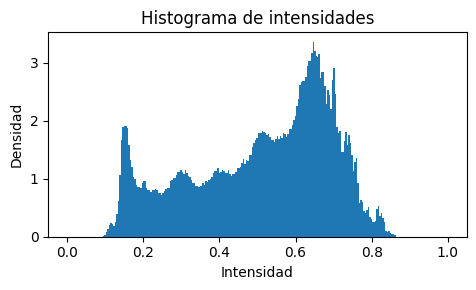

Estimación σ (escala [0,1]): 0.0025  (~ 0.6 en 8 bits)


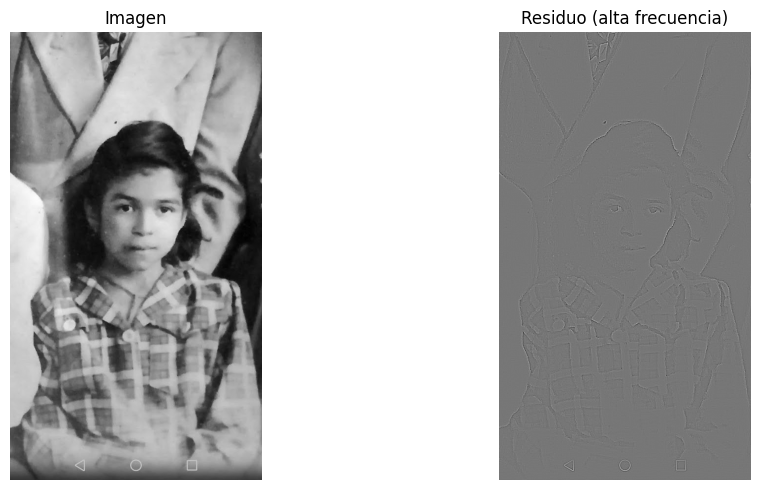

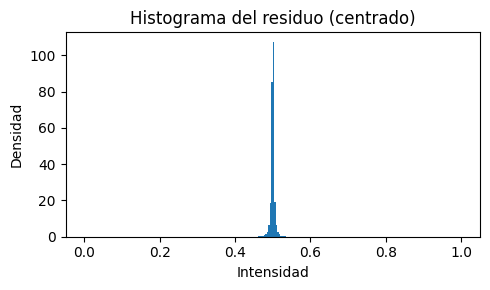

Diagnóstico: gaussian | stats={'spikes_0_1': 0.0, 'skew_resid': -0.5907131433486938}
Corrección: shrinkage local (ventana 3x3)


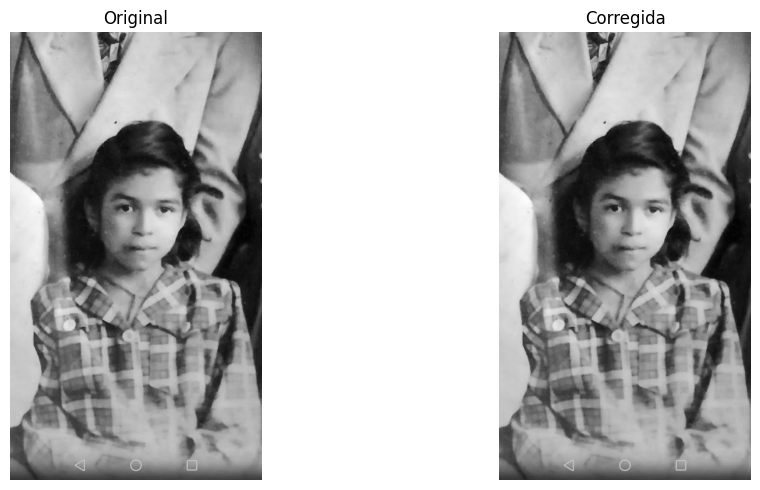


=== Procesando: otra.jpg ===


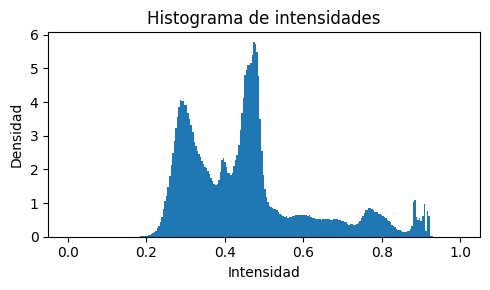

Estimación σ (escala [0,1]): 0.0036  (~ 0.9 en 8 bits)


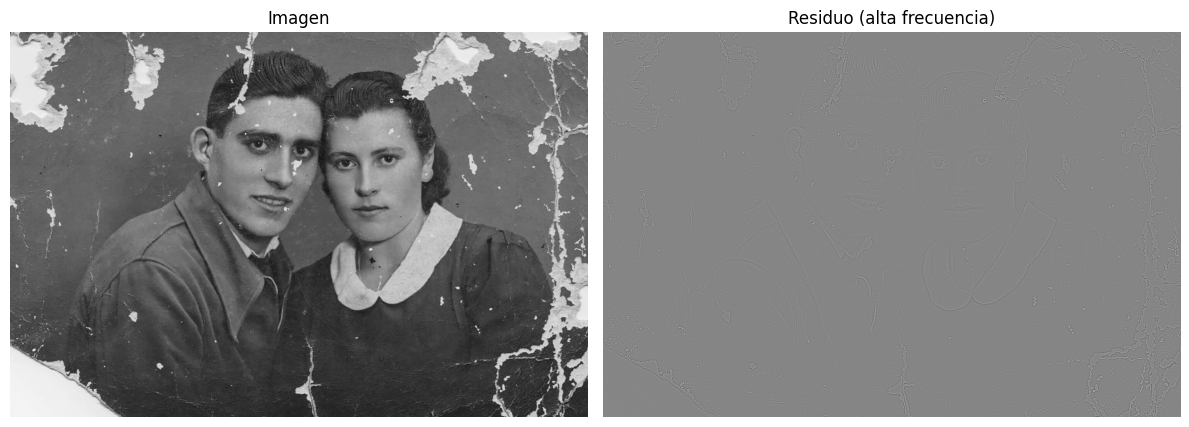

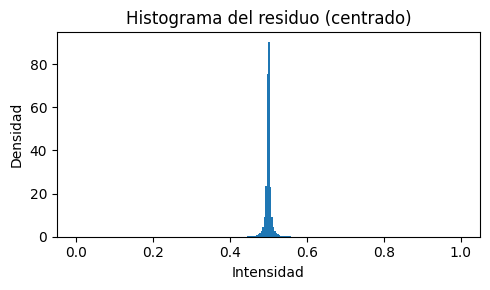

Diagnóstico: gaussian | stats={'spikes_0_1': 0.0, 'skew_resid': 0.43607649207115173}
Corrección: shrinkage local (ventana 3x3)


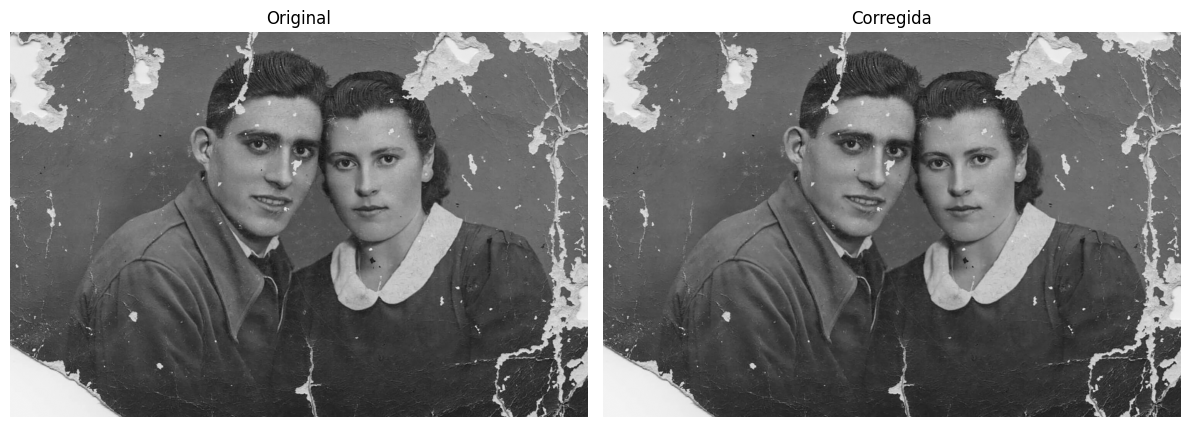


✔ Proceso finalizado. Guarda las figuras en tu PDF del notebook.


In [6]:
# -----------------------------------------
# Pipeline principal (multi-imagen)
# -----------------------------------------

# Añade aquí más rutas; el algoritmo se aplica igual a todas (no ad hoc)
image_paths = [
    "/content/nina.jpg",
    "/content/otra.jpg"  # opcional; si no existe, se ignora
]

for p in image_paths:
    if not Path(p).exists():
        print(f"⚠️  No se encontró {p}. Continúo con las demás.")
        continue

    img = load_gray_float(p)
    print(f"\n=== Procesando: {Path(p).name} ===")

    # 1) Histogramas de intensidades
    show_hist(img, "Histograma de intensidades")

    # 2) Estimar nivel de ruido y ver residuo
    sigma, resid = estimate_noise_sigma(img)
    print(f"Estimación σ (escala [0,1]): {sigma:.4f}  (~ {sigma*255:.1f} en 8 bits)")
    imshow_pair(img, resid, ("Imagen", "Residuo (alta frecuencia)"))
    show_hist(resid + 0.5, "Histograma del residuo (centrado)", bins=256, rng=(0,1))

    # 3) Diagnóstico del tipo de ruido
    ntype, stats = classify_noise(img, resid)
    print(f"Diagnóstico: {ntype} | stats={stats}")

    # 4) Corrección según diagnóstico
    if ntype == "gaussian":
        den, win = denoise_gaussian_shrinkage(img, sigma)
        print(f"Corrección: shrinkage local (ventana {win}x{win})")
    else:
        den = denoise_salt_pepper_adaptive(img)
        print("Corrección: mediana adaptativa 3→5→7")

    # 5) Comparación visual
    imshow_pair(img, den, ("Original", "Corregida"))

print("\n✔ Proceso finalizado. Guarda las figuras en tu PDF del notebook.")
